<a href="https://colab.research.google.com/github/yunmokoo/SPY-Forecast_MARS_LSTM/blob/main/SPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests > make_outputrerquest.txt 2>&1
!pip install yfinance > make_outputyfinance.txt 2>&1
!pip install transformers > make_outputtransformers.txt 2>&1
!pip install xformers > make_outputxformers.txt 2>&1




In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz > wget_output.txt 2>&1
!tar -xzvf ta-lib-0.4.0-src.tar.gz > tar_output.txt 2>&1
%cd ta-lib
!./configure --prefix=/usr > config_output.txt 2>&1
!make > make_outputtalib.txt 2>&1
!make install > makeInstall_output.txt 2>&1
!pip install TA-Lib > pipInstall_output.txt 2>&1

/content/ta-lib


In [2]:
import requests
import json
import yfinance as yf
#import talib

import tensorflow as tf
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from transformers import *
from transformers import GenerationMixin
from transformers import TFGenerationMixin
from transformers import FlaxGenerationMixin

from sklearn.preprocessing import MinMaxScaler

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from transformers import DistilBertTokenizer, DistilBertModel

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(


From TA-lib...

1. MA                  All Moving Average
2. BBANDS              Bollinger Bands
3. MACD                Moving Average Convergence/Divergence
4. SMA                 Simple Moving Average
5. EMA                 Exponential Moving Average

In [93]:
data_SPY = yf.download("SPY", start="2001-01-01", end="2023-01-01")
df = pd.DataFrame(data_SPY)

# Step 4: Separate the data into features (input) and target (output)
features = df[['Open', 'High', 'Low', 'Adj Close', 'Volume']].values
target = df[['Close']].values

# Step 5: Data normalization using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target)

# Step 6: Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 10  # You can adjust this value as needed
X, y = create_sequences(target_scaled, sequence_length)

# Step 7: Split the data into train, test, and cross-validation sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[-test_size:]
y_test = y[-test_size:]

# Step 8: Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Step 9: Reshape the input data to fit the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 10: Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

predicted_scaled = model.predict(X_test)
predicted_close = scaler.inverse_transform(predicted_scaled)
actual_close = scaler.inverse_transform(y_test)

# Step 12: Plot the predicted and actual close values
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(predicted_close):], predicted_close, label='Predicted Close', color='b')
plt.plot(df.index[-len(predicted_close):], actual_close, label='Actual Close', color='g')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predicted Close vs Actual Close')
plt.legend()



plt.show()

[*********************100%***********************]  1 of 1 completed
Epoch 1/50


KeyboardInterrupt: ignored

In [96]:
df = pd.DataFrame(yf.download("QQQ", start="2001-01-01", end="2023-01-01"))
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,58.562500,58.687500,52.437500,53.437500,45.814548,62514100
2001-01-03,52.187500,65.250000,52.156250,62.437500,53.530685,118175700
2001-01-04,61.625000,63.625000,60.234375,61.312500,52.566154,58465400
2001-01-05,61.312500,61.312500,56.000000,56.625000,48.547337,68782000
2001-01-08,56.312500,57.500000,53.515625,57.250000,49.083179,55576500
...,...,...,...,...,...,...
2022-12-23,265.470001,268.040009,263.529999,267.359985,266.581055,39373600
2022-12-27,266.739990,266.850006,263.029999,263.579987,262.812073,38009000
2022-12-28,263.170013,265.470001,259.730011,260.100006,259.342224,47139000


In [103]:


features = df[['Open', 'High','Low']]

target = df[['Close']]


scaler = MinMaxScaler()
features_scaled = scaler.fit(features)
print(" \n This is min feature scaling params after .fit \n " + str(scaler.data_min_))
print(" \n This is max feature scaling params after .fit \n " + str(scaler.data_max_))

features_scaled = scaler.transform(features)

target_scaled = scaler.fit(target)

print(" \n This is min target scaling params after .fit \n " + str(scaler.data_min_))
print(" \n This is max target scaling params after .fit \n " + str(scaler.data_max_))

target_scaled = scaler.transform(target)

print("This is features \n" + str(features_scaled))
print("This is target \n" + str(target_scaled))

 
 This is min feature scaling params after .fit 
 [19.94000053 20.53000069 19.76000023]
 
 This is max feature scaling params after .fit 
 [405.57000732 408.70999146 402.57998657]
 
 This is min target scaling params after .fit 
 [20.05999947]
 
 This is max target scaling params after .fit 
 [403.98999023]
This is features 
[[0.10015429 0.09829847 0.08535996]
 [0.0836229  0.11520429 0.08462528]
 [0.10809584 0.11101809 0.10572691]
 ...
 [0.63073415 0.63099595 0.62684818]
 [0.63018953 0.63596785 0.63343088]
 [0.63190102 0.63341751 0.63353539]]
This is target 
[[0.08693642]
 [0.1103782 ]
 [0.10744798]
 ...
 [0.62521817]
 [0.64173159]
 [0.64131484]]


In [104]:
def initiate_seq(data, seq_len):
  X, y = [], []
  for i in range(len(data) - seq_len):
    X.append(data[i:i + seq_len])
    y.append(data[i + seq_len])
  return np.array(X), np.array(y)

seq_len = 10
X, y = initiate_seq(target_scaled, seq_len)

In [105]:
#lets do 60-20-20, train-test-validation respectively

train_size = int(0.6 * len(X))
test_size = int(0.2 * len(X))
val_size = len(X) - train_size - test_size

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:train_size + test_size]
y_test = y[train_size:train_size + test_size]

X_val = X[-val_size:]
y_val = y[-val_size:]

In [106]:
model = Sequential()
model.add(LSTM(50, input_shape=(seq_len, 1)))


model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss= 'mse')

testing from here


In [107]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


Epoch 1/50
104/104 [==============================] - 1s 7ms/step - loss: 5.6608e-06 - val_loss: 6.3338e-04
Epoch 2/50
104/104 [==============================] - 1s 7ms/step - loss: 5.9673e-06 - val_loss: 2.5883e-04
Epoch 3/50
104/104 [==============================] - 1s 7ms/step - loss: 4.7399e-06 - val_loss: 1.5286e-04
Epoch 4/50
104/104 [==============================] - 1s 7ms/step - loss: 5.3001e-06 - val_loss: 2.9076e-04
Epoch 5/50
104/104 [==============================] - 1s 7ms/step - loss: 6.2438e-06 - val_loss: 0.0016
Epoch 6/50
104/104 [==============================] - 1s 6ms/step - loss: 7.0345e-06 - val_loss: 5.0139e-04
Epoch 7/50
104/104 [==============================] - 1s 7ms/step - loss: 5.6628e-06 - val_loss: 7.3190e-04
Epoch 8/50
104/104 [==============================] - 1s 7ms/step - loss: 5.9153e-06 - val_loss: 1.5064e-04
Epoch 9/50
104/104 [==============================] - 1s 7ms/step - loss: 5.3358e-06 - val_loss: 1.4007e-04
Epoch 10/50
104/104 [===========

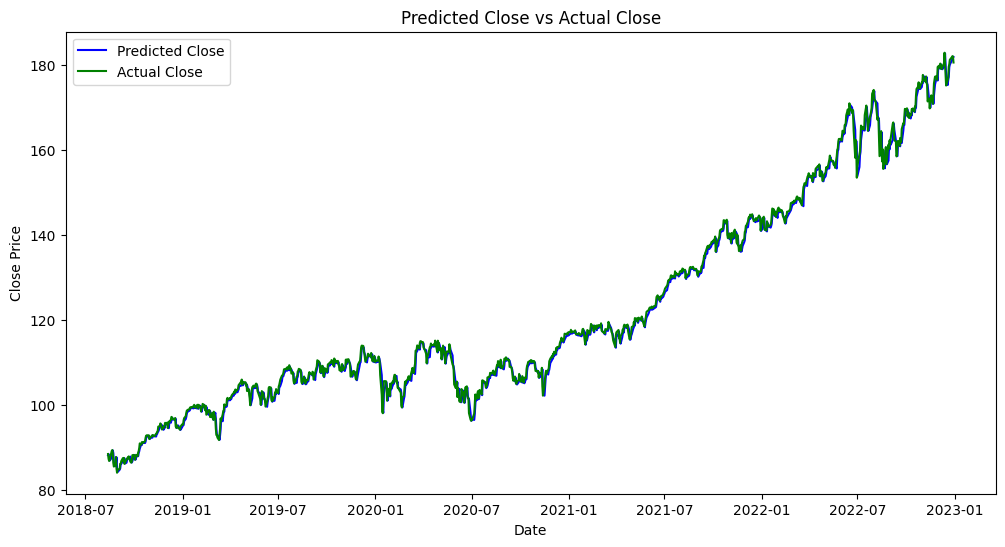

In [109]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

predicted_scaled = model.predict(X_test)
predicted_close = scaler.inverse_transform(predicted_scaled)
actual_close = scaler.inverse_transform(y_test)


plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(predicted_close):], predicted_close, label='Predicted Close', color='b')
plt.plot(df.index[-len(predicted_close):], actual_close, label='Actual Close', color='g')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predicted Close vs Actual Close')
plt.legend()


plt.show()


# Transformer


In [ ]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_normalized

,Open,High,Low,Close,Adj Close,Volume
0,0.155737,0.151608,0.147845,0.148199,0.079748,0.006263
1,0.146771,0.160983,0.148074,0.163306,0.089547,0.018587
2,0.162880,0.159688,0.161140,0.159758,0.087246,0.006818
3,0.159308,0.155190,0.151818,0.149115,0.080342,0.011073
4,0.150570,0.146806,0.148150,0.151556,0.081925,0.003829
...,...,...,...,...,...,...
5530,0.757896,0.763598,0.760294,0.768555,0.791514,0.065175
5531,0.765531,0.763818,0.764256,0.764868,0.787902,0.055703
5532,0.761981,0.764403,0.756358,0.753296,0.776566,0.077915
5533,0.757848,0.766745,0.762862,0.769849,0.792781,0.073373
